In [3]:
import sys, os, pickle
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from functions import *
from ode_methods import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [4]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(mn_corr=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
                                 g=[1, 5, 10, 15, 20])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [27]:
N = 1000
g = params['g']
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))
mn = np.random.multivariate_normal(np.zeros(2), np.array([[4, params['mn_corr']], [params['mn_corr'], 4]]), (N))
m, n = mn[:,0], mn[:,1]

W = J + np.multiply.outer(m, n) / N

In [28]:
rnn = Time_Cts_RNN(W, tanh, g=1)
ode_method = Euler(0.03)
sim = Simulation(rnn)
x_init = np.random.normal(0, 1/np.sqrt(N), N)
sim.run(T=3000, ode_method=ode_method, x_init=x_init, monitors=['rnn.x','t'], T_monitor=None)

Progress: 10.0% complete 
Time Elapsed: 0.5s 

Progress: 20.0% complete 
Time Elapsed: 1.1s 

Progress: 30.0% complete 
Time Elapsed: 1.6s 

Progress: 40.0% complete 
Time Elapsed: 2.1s 

Progress: 50.0% complete 
Time Elapsed: 2.6s 

Progress: 60.0% complete 
Time Elapsed: 3.1s 

Progress: 70.0% complete 
Time Elapsed: 3.7s 

Progress: 80.0% complete 
Time Elapsed: 4.2s 

Progress: 90.0% complete 
Time Elapsed: 4.7s 



In [1]:
if prototype:
    plt.figure()
    for i in range(10):
        plt.plot(sim.mons['t'], sim.mons['rnn.x'][:,i])
#plt.ylim([-10, 10])

NameError: name 'prototype' is not defined

In [30]:
processed_data = sim.mons['rnn.x'][:,:10].copy()
del sim.mons['rnn.x']
del sim.rnn.W

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [31]:
###Truncate file above
file_name = 'rank1_perturbation'
job_name = 'g_structure_regimes'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook rank1_perturbation.ipynb to script
[NbConvertApp] Writing 6138 bytes to rank1_perturbation.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b4b55bf9da0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b4b55bf9da0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [32]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
job_id_1 = submit_job(job_script_path, n_jobs)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/g_structure_regimes/result_*’: No such file or directory
sending incremental file list

sent 3,628 bytes  received 34 bytes  7,324.00 bytes/sec
total size is 427,179  speedup is 116.65


In [35]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            581575    lkumar  jupyter   om2382  R    1:13:57      1 ax14


In [36]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'g_structure_regimes'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

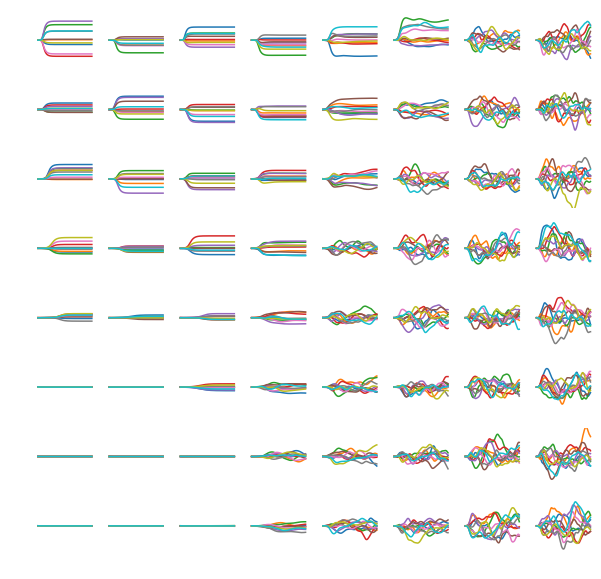

In [47]:
fig, ax = plt.subplots(8, 8, figsize=(10, 10))
for i_s, s in enumerate(configs_array['mn_corr']):
    for i_g, g in enumerate(configs_array['g']):
        
        for i in range(10):
            ax[7 - i_s, i_g].plot(results_array[i_s, i_g, 0, ::10, i], color='C{}'.format(i))
            ax[7 - i_s, i_g].axis('off')
            ax[7 - i_s, i_g].set_ylim([-10, 10])
fig.savefig('figs/fig1b_fracesca2018.pdf', format='pdf')

In [ ]:
theory = []
for g in configs_array['g']:
    theory.append(solve_for_Delta_0(g))
#plt.plot(configs_array['g'], theory, color='k')
for i in range(len(configs_array['n'])):
    fig = plt.figure()
    plt.plot(configs_array['g'], theory, color='k')
    for j in range(len(configs_array['i_seed'])):
        plt.plot(configs_array['g'], results_array[i, :, j], '.', color='C{}'.format(i))
    plt.xlabel('g')
    plt.ylabel('$\Delta_0$')
    plt.title('n = {}'.format(configs_array['n'][i]))
    plt.xticks(configs_array['g'])
    plt.ylim([-0.05, 3.5])
    fig.savefig('figs/delta0_n={}.pdf'.format(configs_array['n'][i]), format='pdf')

In [ ]:
def plot_2d_array_of_time_series(configs_array, results_array, common_ylim=None):
    
    n_x, n_y, n_seeds, n_t = results_array.shape[:]
    keys = [key for key in configs_array.keys()]
    fig, ax = plt.subplots(n_x, n_y, figsize=(10,10))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_seeds):
                ax[i, j].plot(results_array[i,j,k,:], color='C0')
            if common_ylim is not None:
                ax[i, j].set_ylim(common_ylim)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[0, j].set_title('{} = {}'.format(keys[1], configs_array[keys[1]][j]))
            ax[i, 0].set_ylabel('{} = {}'.format(keys[0], configs_array[keys[0]][i]))

In [ ]:
plot_2d_array_of_time_series(configs_array, results_array)

In [ ]:
results_array.shape
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    for j in range(3):
        for k in range(5):
            ax[i,j].plot(results_array[i,j,k,::100], color='C0')
            #ax[i,j].set_ylim([-0.01, 0.01])

#fig.savefig('figs/n_ginit.pdf', format='pdf')

In [ ]:
### --- Plot examples with one task --- ###
task = Flip_Flop_Task(3, 0.05)
data = task.gen_data(1000, 1000) #generate data from task
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array,
                                             key_order, sim_dict, data=data,
                                             task_dict=None, N_task_data=1000,
                                             xlim=20, trace_spacing=3)

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order,
                                            tick_rounding=5, vmin=0, vmax=0.9)